In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = [load_array[0][20], load_array[0][50]]
inh = [load_array[1][20], load_array[1][50]]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

file_ = 'up.pickle'

c_var = [0,1]
if len(folder) == 4:
    if folder[3] == 'e':
        p_var = [0]
    elif folder[3] == 'i':
        p_var = [1]
else:
    p_var = [0,1]
    
print(p_var)

step1 = 1
step2 = 10
step3 = 100

/1_e
[0]


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
d_array = np.arange(20., 300, 0.1)
t0_array = d_array - 20.
t_pen = np.zeros(( t0_array.shape ))
for i in range(len(t_pen)):
    t_pen[i] = t0_array[i] / d_array[i] 

In [5]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-8
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [1000., -1000., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [6]:
bestControl_ = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_ = np.array( [[None] * len(t_pen)] * len(exc) )
cost_ = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_ = np.array( [[None] * len(t_pen)] * len(exc) )
weights_ = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_ = np.array( [[None] * len(t_pen)] * len(exc) )

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

print(bestControl_.shape)

(2, 2800)


In [84]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [8]:
# get initial parameters and target states
# -------  20 0.4500000000000001 0.4750000000000002
#-------  50 0.47500000000000014 0.6000000000000003

i_range = range(len(exc))
data.set_parameters(aln)

i_range = [0]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  0 0.4500000000000001 0.4750000000000002


In [145]:
# get uncontrolled cost

data.set_parameters(aln)
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    dur = 500.
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
    
    wp = 1. / 20.
    print(wp)
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()
    
    print(t_pen[0], dur, dur_pre, dur_post)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = 0.96)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4500000000000001 0.4750000000000002
0.05
set cost params:  0.05 0.0 0.0
0.0 500.0 10 10
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225135838
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [70]:
tol = 1e-6

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    cgv = None
    j = 0
    max_it = 10000

    while not convergence_[i][j]:

        dur = d_array[0]
        aln.params.duration = dur
        wp = 1. / (dur - t_pen[j] * dur)
        
        cost.setParams(wp, 0., 1.)
        weights_[i][j] = [wp, 0., 1.]
        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None) or np.amax(np.abs(bestControl_[i][j])) < 1e-6:
            control0 = aln.getZeroControl()
            control0[0,0,:100] = 5.
        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if max_it > 1:
            if cost_[i][j][2] == 0.:
                convergence_[i][j] = True
                continue

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2106.2323950812834
RUN  0 , total integrated cost =  2106.2323950812834
Gradient descend method:  None
RUN  1 , total integrated cost =  607.3989757206173
RUN  2 , total integrated cost =  437.99905862053896
RUN  3 , total integrated cost =  437.22979047251175
RUN  4 , total integrated cost =  436.4187840029227
RUN  5 , total integrated cost =  408.34576940822956
RUN  6 , total integrated cost =  388.19551630984955
RUN  7 , total integrated cost =  377.9493663820642
RUN  8 , total integrated cost =  367.4699679682191
RUN  9 , total integrated cost =  360.33147595087274
RUN  10 , total integrated cost =  353.2098523903489
RUN  11 , total integrated cost =  347.1660471669894
RUN  12 , total integrated cost =  340.78370937412046
RUN  13 , total integrated cost =  335.44310678027585
RUN  14 , total integrated cost =  331.21936185048855
RUN  15 , total integr

In [73]:
i = 0

for j in range(1,2000):
    #bestControl_[i][j] = None
    convergence_[i][j] = None

In [74]:
tol = 1e-6

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 1
    step = step1
    
    if j >= 10:
        step = step2
    if j >=1000:
        step = step3

    while j < 2001:
        
        if convergence_[i][j]:
            j += step
            if j >= 10:
                step = step2
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(1000)  
        wp = 1. / (dur - t_pen[j] * dur)
        
        cost.setParams(wp, 0., 1.)

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_[i][j-step][:,:,n_pre-1:-n_post+1]

        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]
            
        weights_[i][j] = cost.getParams()

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_[i][j][-1] == 0.:
            convergence_[i][j] = True
            if j >= 10:
                step = step2

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
----- 1
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  38.03181708892244
RUN  0 , total integrated cost =  38.03181708892244
Gradient descend method:  None
RUN  1 , total integrated cost =  38.03181708892244
Control only changes marginally.
RUN  1 , total integrated cost =  38.03181708892244
Improved over  1  iterations in  0.06630550899717491  seconds by  0.0  percent.
cost splitting :  [256.92925931   0.        ] [2.51853541e+01 9.05095231e-11]
----- 2
set cost params:  0.05000000000000001 0.0 1.0
interpolate adjoint :  True True True
initial cost =  34.848487696694676
RUN  0 , total integrated cost =  34.848487696694676
Gradient descend method:  None
RUN  1 , total integrated cost =  34.84848769026089
RUN  2 , total integrated cost =  34.84848768809868
RUN  3 , total integrated cost =  34.84848768653101
RUN  4 , total integrated cost =  34.848487685294394
RUN  5 , total integrated cost =  34.84848

KeyboardInterrupt: 

In [26]:
i = 0
aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

for j in range(len(t_pen)):
    #convergence_[0][j] = None
    continue
    print("------- ", j)
    
    dur = round(d_array[j],1)
    aln.params.duration = dur
    
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_[i][j][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_[i][j][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_[i][j][0,0,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_[i][j][0,1,n_pre-1:-n_post+1], color = 'red')

    for k in range(2):
        ax[k].set_xlim(0.,dur)
    plt.show()

In [113]:
bestControl_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
cost_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
weights_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_maxW = np.array( [[None] * len(t_pen)] * len(exc) )

file_maxW = 'up_Wmax.pickle'

In [115]:
if os.path.isfile(file_maxW) :
    print("file found")
    
    with open(file_maxW,'rb') as f:
        load_array = pickle.load(f)

    bestControl_maxW = load_array[0]
    bestState_maxW = load_array[1]
    cost_maxW = load_array[2]
    costnode_maxW = load_array[3]
    weights_maxW = load_array[4]

file found


-------  0 0.4500000000000001 0.4750000000000002
58.08833869976364
set cost params:  0.05 0.0 58.08833869976364
interpolate adjoint :  True True True
initial cost =  640.0903516261517
RUN  0 , total integrated cost =  640.0903516261517
Gradient descend method:  None
RUN  1 , total integrated cost =  640.0903516261517
Control only changes marginally.
RUN  1 , total integrated cost =  640.0903516261517
Improved over  1  iterations in  0.05615393302286975  seconds by  0.0  percent.


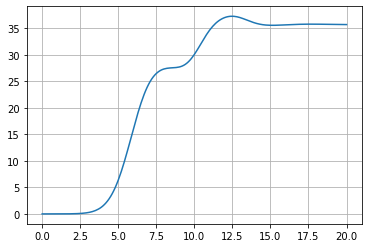

cost splitting :  [384.31042381   0.        ] [2.51853541e+01 9.05095231e-11]


In [116]:
tol = 1e-6

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0

    while not convergence_maxW[i][j]:

        dur = d_array[0]
        aln.params.duration = dur        
        setinit(initVars[i], aln)
        
        wp = 1. / (dur - t_pen[j] * dur)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        if type(bestControl_maxW[i][j]) == type(None):
            max_it = 10
            control0 = bestControl_[i][0][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - wp * sum(costnode_[i][j][0][0][:]) ) / sum( costnode_[i][j][2][0][:] )
            weight_ = 2.
            cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - wp * sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][2][0][:] )
            print(weight_)
            #weight_ = 4.
            cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
            max_it = int(100)

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True
            
        plt.plot(np.arange(0,20.1,0.1), bestState_maxW[i][j][0,0,100:-100])
        plt.show()

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)

In [150]:
tol =1e-6

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 1
    step = step1

    while j < 2001:
        
        if j >= 60:
            step = step2
        if j >= 1100:
            step = step3
        
        if convergence_maxW[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(10000)  
        wp = 1. / (dur - t_pen[j] * dur)

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_maxW[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_maxW[i][j-step][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i]
                          - wp * sum(costnode_maxW[i][j-step][0][0][:]) ) / sum( costnode_maxW[i][j-step][2][0][:] )

        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i]
                           - wp * sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][2][0][:] )
            
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_maxW[i][j] = cost.getParams()

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_maxW[i][j][0][0][:2], costnode_maxW[i][j][2][0][:2])

    with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)          

-------  0 0.4500000000000001 0.4750000000000002
----- 1090
set cost params:  0.050000000000000606 0.0 168.57245520546147
interpolate adjoint :  True True True
initial cost =  636.9058225135839
RUN  0 , total integrated cost =  636.9058225135839
Gradient descend method:  None
RUN  1 , total integrated cost =  636.9050324580347
RUN  2 , total integrated cost =  636.9034314853163
RUN  3 , total integrated cost =  636.9020441414015
RUN  4 , total integrated cost =  636.7271803685431
RUN  5 , total integrated cost =  636.6836392041507
RUN  6 , total integrated cost =  636.6831217424058
RUN  7 , total integrated cost =  636.6826818311775
RUN  8 , total integrated cost =  636.6823622835675
RUN  9 , total integrated cost =  636.6820782902289
RUN  10 , total integrated cost =  636.681528837581
RUN  11 , total integrated cost =  636.6810358902038
RUN  12 , total integrated cost =  636.680768554239
RUN  13 , total integrated cost =  636.6805045033731
RUN  14 , total integrated cost =  636.679825

RUN  2 , total integrated cost =  636.9005159505317
RUN  3 , total integrated cost =  636.9005107978137
RUN  4 , total integrated cost =  636.9005016556756
RUN  5 , total integrated cost =  636.9004973731568
RUN  6 , total integrated cost =  636.9004759984581
RUN  7 , total integrated cost =  636.9004598615281
RUN  8 , total integrated cost =  636.9004328611004
RUN  9 , total integrated cost =  636.9004006670419
RUN  10 , total integrated cost =  636.9003926216812
RUN  11 , total integrated cost =  636.90038124642
RUN  12 , total integrated cost =  636.9003773468679
RUN  13 , total integrated cost =  636.9003683238391
RUN  14 , total integrated cost =  636.9003628206681
RUN  15 , total integrated cost =  636.9003250909075
RUN  16 , total integrated cost =  636.9002936999757
RUN  17 , total integrated cost =  636.900263857965
RUN  18 , total integrated cost =  636.900230884188
RUN  19 , total integrated cost =  636.900224070021
RUN  20 , total integrated cost =  636.9002134934759
RUN  3

RUN  1 , total integrated cost =  636.9057671696854
RUN  2 , total integrated cost =  636.9057215612856
RUN  3 , total integrated cost =  636.9056450620253
RUN  4 , total integrated cost =  636.9055736930497
RUN  5 , total integrated cost =  636.904977709524
RUN  6 , total integrated cost =  636.9043657673196
RUN  7 , total integrated cost =  636.9043448135604
RUN  8 , total integrated cost =  636.9043174284873
RUN  9 , total integrated cost =  636.9043047754018
RUN  10 , total integrated cost =  636.904283833372
RUN  11 , total integrated cost =  636.9042687604225
RUN  12 , total integrated cost =  636.9042396626519
RUN  13 , total integrated cost =  636.9042163144236
RUN  14 , total integrated cost =  636.9040899485886
RUN  15 , total integrated cost =  636.9039815421186
RUN  16 , total integrated cost =  636.9037926533035
RUN  17 , total integrated cost =  636.9036127265083
RUN  18 , total integrated cost =  636.9035888560653
RUN  19 , total integrated cost =  636.9035574983185
RUN 

RUN  15 , total integrated cost =  636.9028325136888
RUN  16 , total integrated cost =  636.9028183491483
RUN  17 , total integrated cost =  636.902796780376
RUN  18 , total integrated cost =  636.9027838886052
RUN  19 , total integrated cost =  636.902759751858
RUN  20 , total integrated cost =  636.9027429945545
Control only changes marginally.
RUN  21 , total integrated cost =  636.9027429945545
Improved over  21  iterations in  2.406812005006941  seconds by  0.000483512462977842  percent.
cost splitting :  [1.38532316 0.        ] [3.76246904e+00 9.05095231e-11]
----- 1200
set cost params:  0.050000000000000606 0.0 169.26027801108498
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  1 , total integrated cost =  636.9057540217024
RUN  2 , total integrated cost =  636.9056967933194
RUN  3 , total integrated cost =  636.9050827249554
RUN  4 , total integrated cost =  636.904390

RUN  1 , total integrated cost =  636.9057407167749
RUN  2 , total integrated cost =  636.9056664859279
RUN  3 , total integrated cost =  636.9054937233194
RUN  4 , total integrated cost =  636.9052920717564
RUN  5 , total integrated cost =  636.9052542533981
RUN  6 , total integrated cost =  636.9052088749291
RUN  7 , total integrated cost =  636.9051912382995
RUN  8 , total integrated cost =  636.9051681845373
RUN  9 , total integrated cost =  636.9051547763063
RUN  10 , total integrated cost =  636.9051327851322
RUN  11 , total integrated cost =  636.9051178814408
RUN  12 , total integrated cost =  636.9050836584192
RUN  13 , total integrated cost =  636.9050590635153
RUN  14 , total integrated cost =  636.9050590635153
Control only changes marginally.
RUN  14 , total integrated cost =  636.9050590635153
Improved over  14  iterations in  1.5035047180135734  seconds by  0.00011986859620094492  percent.
cost splitting :  [1.38935268 0.        ] [3.76236556e+00 9.05095231e-11]
----- 12

RUN  4 , total integrated cost =  636.9053371785498
RUN  5 , total integrated cost =  636.9052954541886
RUN  6 , total integrated cost =  636.9052380458206
RUN  7 , total integrated cost =  636.9052256622647
RUN  8 , total integrated cost =  636.9052029349208
RUN  9 , total integrated cost =  636.9051921660479
RUN  10 , total integrated cost =  636.9051590157893
RUN  11 , total integrated cost =  636.9051372152207
RUN  12 , total integrated cost =  636.9047224811682
RUN  13 , total integrated cost =  636.90433195269
RUN  14 , total integrated cost =  636.9042461637769
RUN  15 , total integrated cost =  636.9041473031795
RUN  16 , total integrated cost =  636.9041319742275
RUN  17 , total integrated cost =  636.9041082193621
RUN  18 , total integrated cost =  636.9040973912187
RUN  19 , total integrated cost =  636.9040715129701
RUN  20 , total integrated cost =  636.9040536169466
Control only changes marginally.
RUN  29 , total integrated cost =  636.9029312850054
Improved over  29  it

RUN  1 , total integrated cost =  636.9016763321173
RUN  2 , total integrated cost =  636.9016763321173
Control only changes marginally.
RUN  2 , total integrated cost =  636.9016763321173
Improved over  2  iterations in  0.3742715999833308  seconds by  0.0006509881555416541  percent.
cost splitting :  [0.04786377 0.        ] [3.76926509e+00 9.05095231e-11]
----- 1700
set cost params:  0.05000000000000064 0.0 168.9728408167334
interpolate adjoint :  True True True
initial cost =  636.9058225135836
RUN  0 , total integrated cost =  636.9058225135836
Gradient descend method:  None
RUN  1 , total integrated cost =  636.9058225135836
Control only changes marginally.
RUN  1 , total integrated cost =  636.9058225135836
Improved over  1  iterations in  0.18965128899435513  seconds by  0.0  percent.
cost splitting :  [0.04786377 0.        ] [3.76926509e+00 9.05095231e-11]
----- 1800
set cost params:  0.05000000000000064 0.0 168.97183210024087
interpolate adjoint :  True True True
initial cost 

In [148]:
i = 0

for j in range(1,2001):
    #bestControl_maxW[i][j] = None
    convergence_maxW[i][j] = None